kaggle 데이터를 사용하여 만든 다중 분류 모델

## 0. Import Library

In [17]:
!pip install tqdm
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input  
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import tensorflow as tf

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Data

In [3]:
# 경로 설정
data_dir = "../kaggle/"

# 이미지 리스트 
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# 카테고리 리스트 및 경로 초기화
path_list = ["Mild Dementia", "Moderate Dementia", 
             "Non Demented", "Very mild Dementia"]

In [4]:
# 카테고리 별 이미지 경로 저장을 위한 딕셔너리 초기화
image_paths = {
    "Mild Dementia": [],
    "Moderate Dementia": [],
    "Non Demented": [],
    "Very mild Dementia": []
}

# 각 카테고리 별 경로 추가
for category in path_list:
    category_dir = os.path.join(data_dir, category)
    for dirname, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_paths[category].append(os.path.join(dirname, filename))

# 확인
for category in path_list:
    print(f'{category}: {len(image_paths[category])} images')

Mild Dementia: 5002 images
Moderate Dementia: 488 images
Non Demented: 67222 images
Very mild Dementia: 13725 images


In [5]:
# 각 카테고리별 파일 경로 리스트
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

images, labels = [], []

In [6]:
# 각 카테고리 폴더 내 파일 경로를 리스트에 추가
for category in tqdm(path_list):
    category_dir = os.path.join(data_dir, category)
    for root, _, filenames in os.walk(category_dir):
        for filename in filenames:
            image_path = os.path.join(root, filename)
            images.append(image_path)
            labels.append(category)
            if category == "Non Demented":
                non_demented.append(image_path)
            elif category == "Very mild Dementia":
                very_mild_demented.append(image_path)
            elif category == "Mild Dementia":
                mild_demented.append(image_path)
            elif category == "Moderate Dementia":
                moderate_demented.append(image_path)

100%|██████████| 4/4 [00:00<00:00, 33.62it/s]


In [7]:
# 이미지 경로와 레이블을 포함하는 DataFrame 생성
df = pd.DataFrame({'image': images, 'label': labels})
df.head() 

,image,label
0,../kaggle/Mild Dementia/OAS1_0137_MR1_mpr-3_13...,Mild Dementia
1,../kaggle/Mild Dementia/OAS1_0291_MR1_mpr-3_10...,Mild Dementia
2,../kaggle/Mild Dementia/OAS1_0278_MR1_mpr-2_11...,Mild Dementia
3,../kaggle/Mild Dementia/OAS1_0382_MR1_mpr-4_12...,Mild Dementia
4,../kaggle/Mild Dementia/OAS1_0316_MR1_mpr-1_14...,Mild Dementia


/var/folders/s1/nf_zq41n2nd447kv5d44gx2h0000gn/T/ipykernel_21529/1748014159.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df.label,palette='Set1')


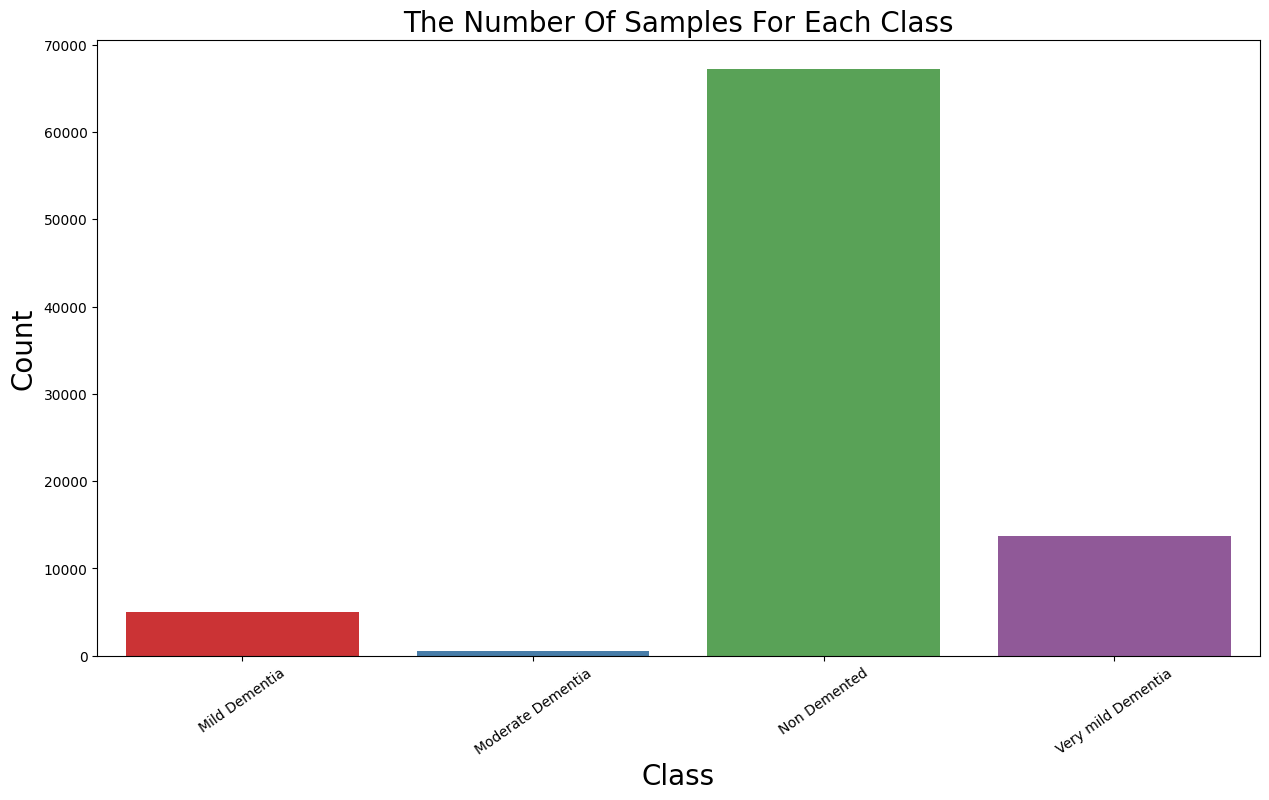

In [8]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(False)
plt.xticks(rotation=35)
plt.show()

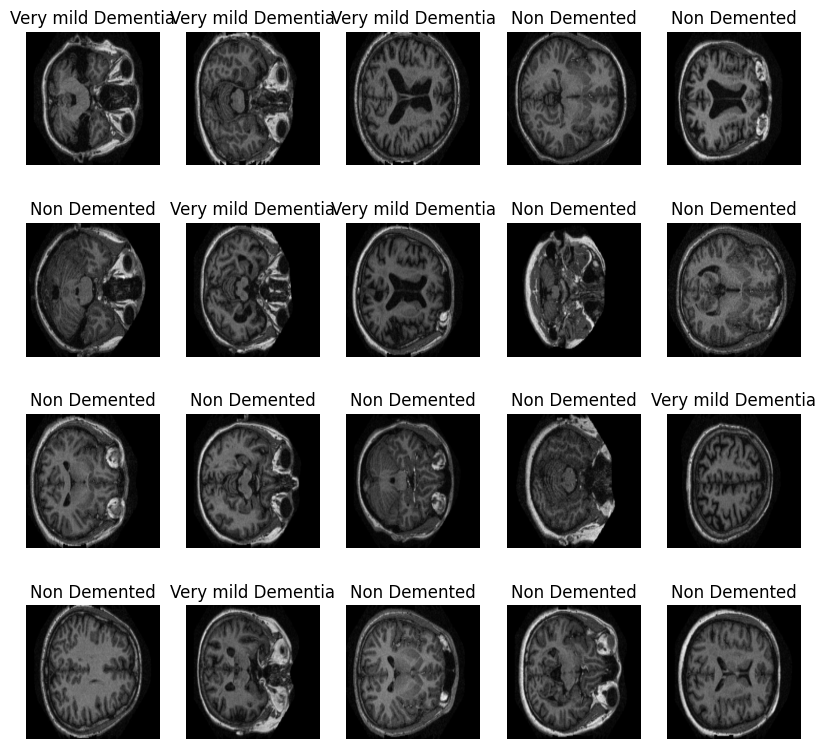

In [9]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

## 2. Preprocessing

In [10]:
data = []
result = []

### 1) Label Encoding

In [11]:
encoder= OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [12]:
# 각 리스트에서 이미지를 읽어와 데이터와 결과에 추가하는 함수
def load_images(category_list, label):
    for image_path in category_list:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img = np.array(img)
        data.append(img)
        result.append(encoder.transform([[label]]).toarray())

In [13]:
# 각 카테고리별로 이미지 로드
load_images(non_demented, 0)
load_images(very_mild_demented, 1)
load_images(mild_demented, 2)
load_images(moderate_demented, 3)

In [14]:
# 결과 데이터 변환 확인
data = np.array(data)
result = np.array(result).reshape(len(result), -1)
print(f"Data shape: {data.shape}, Result shape: {result.shape}")

Data shape: (86437, 128, 128, 3), Result shape: (86437, 4)


### 2) Reshape data

In [15]:
X=np.array(data)
y=np.array(result)
y=y.reshape(X.shape[0],4)
y=np.argmax(y, axis=1)

### 3) Split data

In [16]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=42, shuffle = True)
X_train.shape
X_test.shape

(17288, 128, 128, 3)

## 3. Modeling

In [17]:
# CNN 모델 생성
def create_compile_model():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',input_shape = (128,128,3)))

    model.add(Conv2D(filters=32,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=64,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(Conv2D(filters=128,kernel_size=2,padding='Same',activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4,activation='softmax'))

    print(model.summary())

    model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [18]:
early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

checkpoint = ModelCheckpoint(
    filepath='../model/multi_model.keras',  
    monitor='val_loss',       
    save_best_only=True,       
    mode='min',               
    verbose=1               
)

## 4. Training

In [19]:
model = create_compile_model()

/Users/chaewon/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,518,596 (32.50 MB)

 Trainable params: 8,518,148 (32.49 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [23]:
history= model.fit(X_train,
                   y_train,
                   validation_split=0.2,
                   epochs=15,
                   callbacks=[early_stopping, checkpoint],
                    batch_size=32)

Epoch 1/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7987 - loss: 0.4985
Epoch 1: val_loss improved from inf to 0.29170, saving model to ../model/multi_model.keras
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 601s 347ms/step - accuracy: 0.7987 - loss: 0.4985 - val_accuracy: 0.8837 - val_loss: 0.2917
Epoch 2/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8909 - loss: 0.2542
Epoch 2: val_loss improved from 0.29170 to 0.14601, saving model to ../model/multi_model.keras
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 627s 362ms/step - accuracy: 0.8909 - loss: 0.2542 - val_accuracy: 0.9422 - val_loss: 0.1460
Epoch 3/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9320 - loss: 0.1625
Epoch 3: val_loss improved from 0.14601 to 0.05525, saving model to ../model/multi_model.keras
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 605s 350ms/step - accuracy: 0.9320 - loss: 0.1625 - val_accuracy: 0.9832 - val_loss: 0.0553
Epoch 4/15
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9524 - los

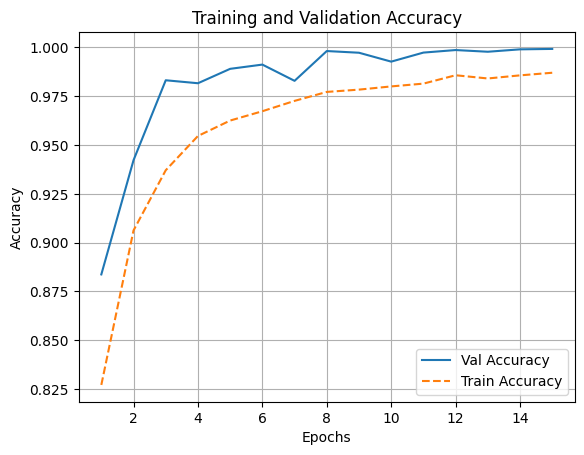

In [24]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

plt.plot(epochs, val_accuracy,  label=f'Val Accuracy')
plt.plot(epochs, train_accuracy, linestyle='--', label=f'Train Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

### 데이터 편차 확인

541/541 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step


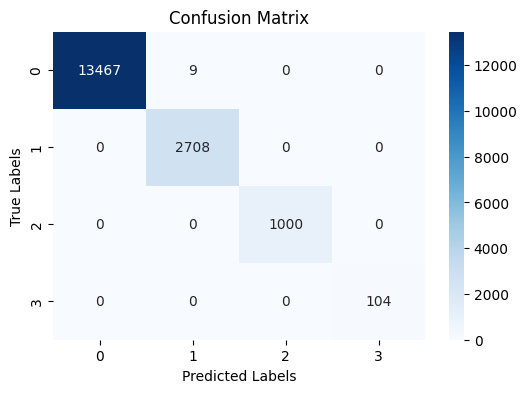

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### GradCAM 확인

In [ ]:
# def load_and_preprocess_image(image_path):
#     img = load_img(image_path, target_size=(224, 224))  # 모델에 맞는 크기로 조정
#     img_array = img_to_array(img)  # 이미지를 배열로 변환
#     img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가
#     img_array = preprocess_input(img_array)  # 전처리 (예: VGG16의 경우)
#     return img_array

# def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
#     # 모델의 마지막 컨볼루션 레이어 가져오기
#     last_conv_layer = model.get_layer(last_conv_layer_name)
    
#     # 모델의 그래디언트를 가져오기 위한 Grad-CAM 모델 정의
#     grad_model = Model([model.inputs], [last_conv_layer.output, model.output])
    
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)  # 예측 결과와 마지막 레이어의 출력
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])  # 예측 인덱스가 주어지지 않으면 자동으로 선택
#         class_channel = preds[0][pred_index]  # 해당 클래스의 채널 선택
    
#     # 그래디언트 계산
#     grads = tape.gradient(class_channel, last_conv_layer_output)  # 마지막 컨볼루션 레이어의 그래디언트
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # 각 채널의 그래디언트 평균
    
#     # 히트맵 계산
#     last_conv_layer_output = last_conv_layer_output[0]  # 배치 차원 제거
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]  # 채널 가중치와 곱하기
#     heatmap = tf.squeeze(heatmap)  # 불필요한 차원 제거
#     heatmap = tf.nn.relu(heatmap)  # ReLU 활성화
#     heatmap /= tf.reduce_max(heatmap)  # 정규화
    
#     return heatmap.numpy()  # 히트맵을 numpy 배열로 반환

# def display_gradcam(img_path, heatmap, cam_path='cam.jpg', alpha=0.4):
#     # 원본 이미지 로드
#     img = load_img(img_path, target_size=(224, 224))
#     img = img_to_array(img) / 255.0  # 0-1로 정규화
    
#     # 히트맵 크기를 원본 이미지 크기로 조정
#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
#     # 히트맵을 컬러 맵으로 변환
#     heatmap = np.uint8(255 * heatmap)  # 0-255로 변환
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # 컬러 맵 적용
    
#     # 원본 이미지와 히트맵을 합성
#     superimposed_img = heatmap * alpha + img  # 히트맵을 원본 이미지에 추가
#     cv2.imwrite(cam_path, superimposed_img * 255)  # 이미지 저장
    
#     # 결과 표시
#     plt.imshow(superimposed_img)
#     plt.axis('off')
#     plt.show()


# # 전처리 및 Grad-CAM 적용할 이미지 수 설정
# num_images_to_process = 5  
# for index, row in df.iterrows():
#     if index >= num_images_to_process:  # 설정한 이미지 수를 초과하면 종료
#         break
    
#     img_path = row['image']
#     # 이미지 로드 및 전처리
#     img = load_img(img_path, target_size=(224, 224))
#     img_array = img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     # 마지막 컨볼루션 레이어의 이름
#     last_conv_layer_name = "conv2d_3"  # 수정할 수 있어

#     # Grad-CAM 히트맵 생성
#     heatmap = get_gradcam_heatmap(model, img_array[0], last_conv_layer_name)

#     # 원본 이미지와 히트맵 결합
#     heatmap = cv2.resize(heatmap, (224, 224))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#     superimposed_img = heatmap * 0.4 + img_array[0] * 255

#     # Grad-CAM 결과 출력
#     display_gradcam(img_array[0], superimposed_img, row['label'])

In [ ]:
# # 모든 이미지를 전처리하여 리스트에 저장
# preprocessed_images = []
# heatmaps = []

# for index, row in df.iterrows():
#     image_path = row['image']  # 경로 가져오기
#     preprocessed_image = load_and_preprocess_image(image_path)
#     preprocessed_images.append(preprocessed_image)

# # 리스트를 numpy 배열로 변환
# preprocessed_images = np.vstack(preprocessed_images)

# # 모델을 로드
# model = tf.keras.models.load_model('multi_model.h5')  # 네가 사용하는 모델 경로로 수정

# # Grad-CAM 실행
# last_conv_layer_name = "last_conv_layer"  # 마지막 컨볼루션 레이어 이름을 맞게 수정
# for i in range(len(preprocessed_images)):
#     heatmap = get_gradcam_heatmap(model, preprocessed_images[i:i+1], last_conv_layer_name)  # 히트맵 계산
#     heatmaps.append(heatmap)

#     # 히트맵을 원본 이미지에 오버레이
#     display_gradcam(df['image'][i], heatmap)